In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

import glob
from pandas.core.common import flatten
import random
from PIL import Image
import os

plt.rcParams['figure.dpi'] = 600

### Generate random CIFAR subset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

seed = 0
batch_size = 4

torch.manual_seed(seed)
random.seed(seed)

# Load full CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Specify the number of samples for the desired subset
subset_size = int(0.1 * len(trainset)) # (10% of the dataset)

# Create a random subset of the CIFAR-10 dataset
indices = torch.randperm(len(trainset))[:subset_size]

subset_trainset = Subset(trainset, indices)
subset_trainloader = torch.utils.data.DataLoader(subset_trainset, batch_size=batch_size,
                                          num_workers=2)

classes = ('Plane', 'Car', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

### Calculate class distribution

In [3]:
# Create a dictionary to store the label counts
label_counts = {label: 0 for label in range(10)}

# Iterate through the subset and count the occurrences of each label
for images, labels in subset_trainloader:
    for label in labels:
        label_counts[label.item()] += 1

# Print the label counts
print("Class distribution in the subset:")
for label, count in label_counts.items():
    print(f"{classes[label]}: {count} samples")

Class distribution in the subset:
Plane: 511 samples
Car: 510 samples
Bird: 506 samples
Cat: 509 samples
Deer: 502 samples
Dog: 472 samples
Frog: 500 samples
Horse: 470 samples
Ship: 500 samples
Truck: 520 samples


### Plot class distribution (fairly even)

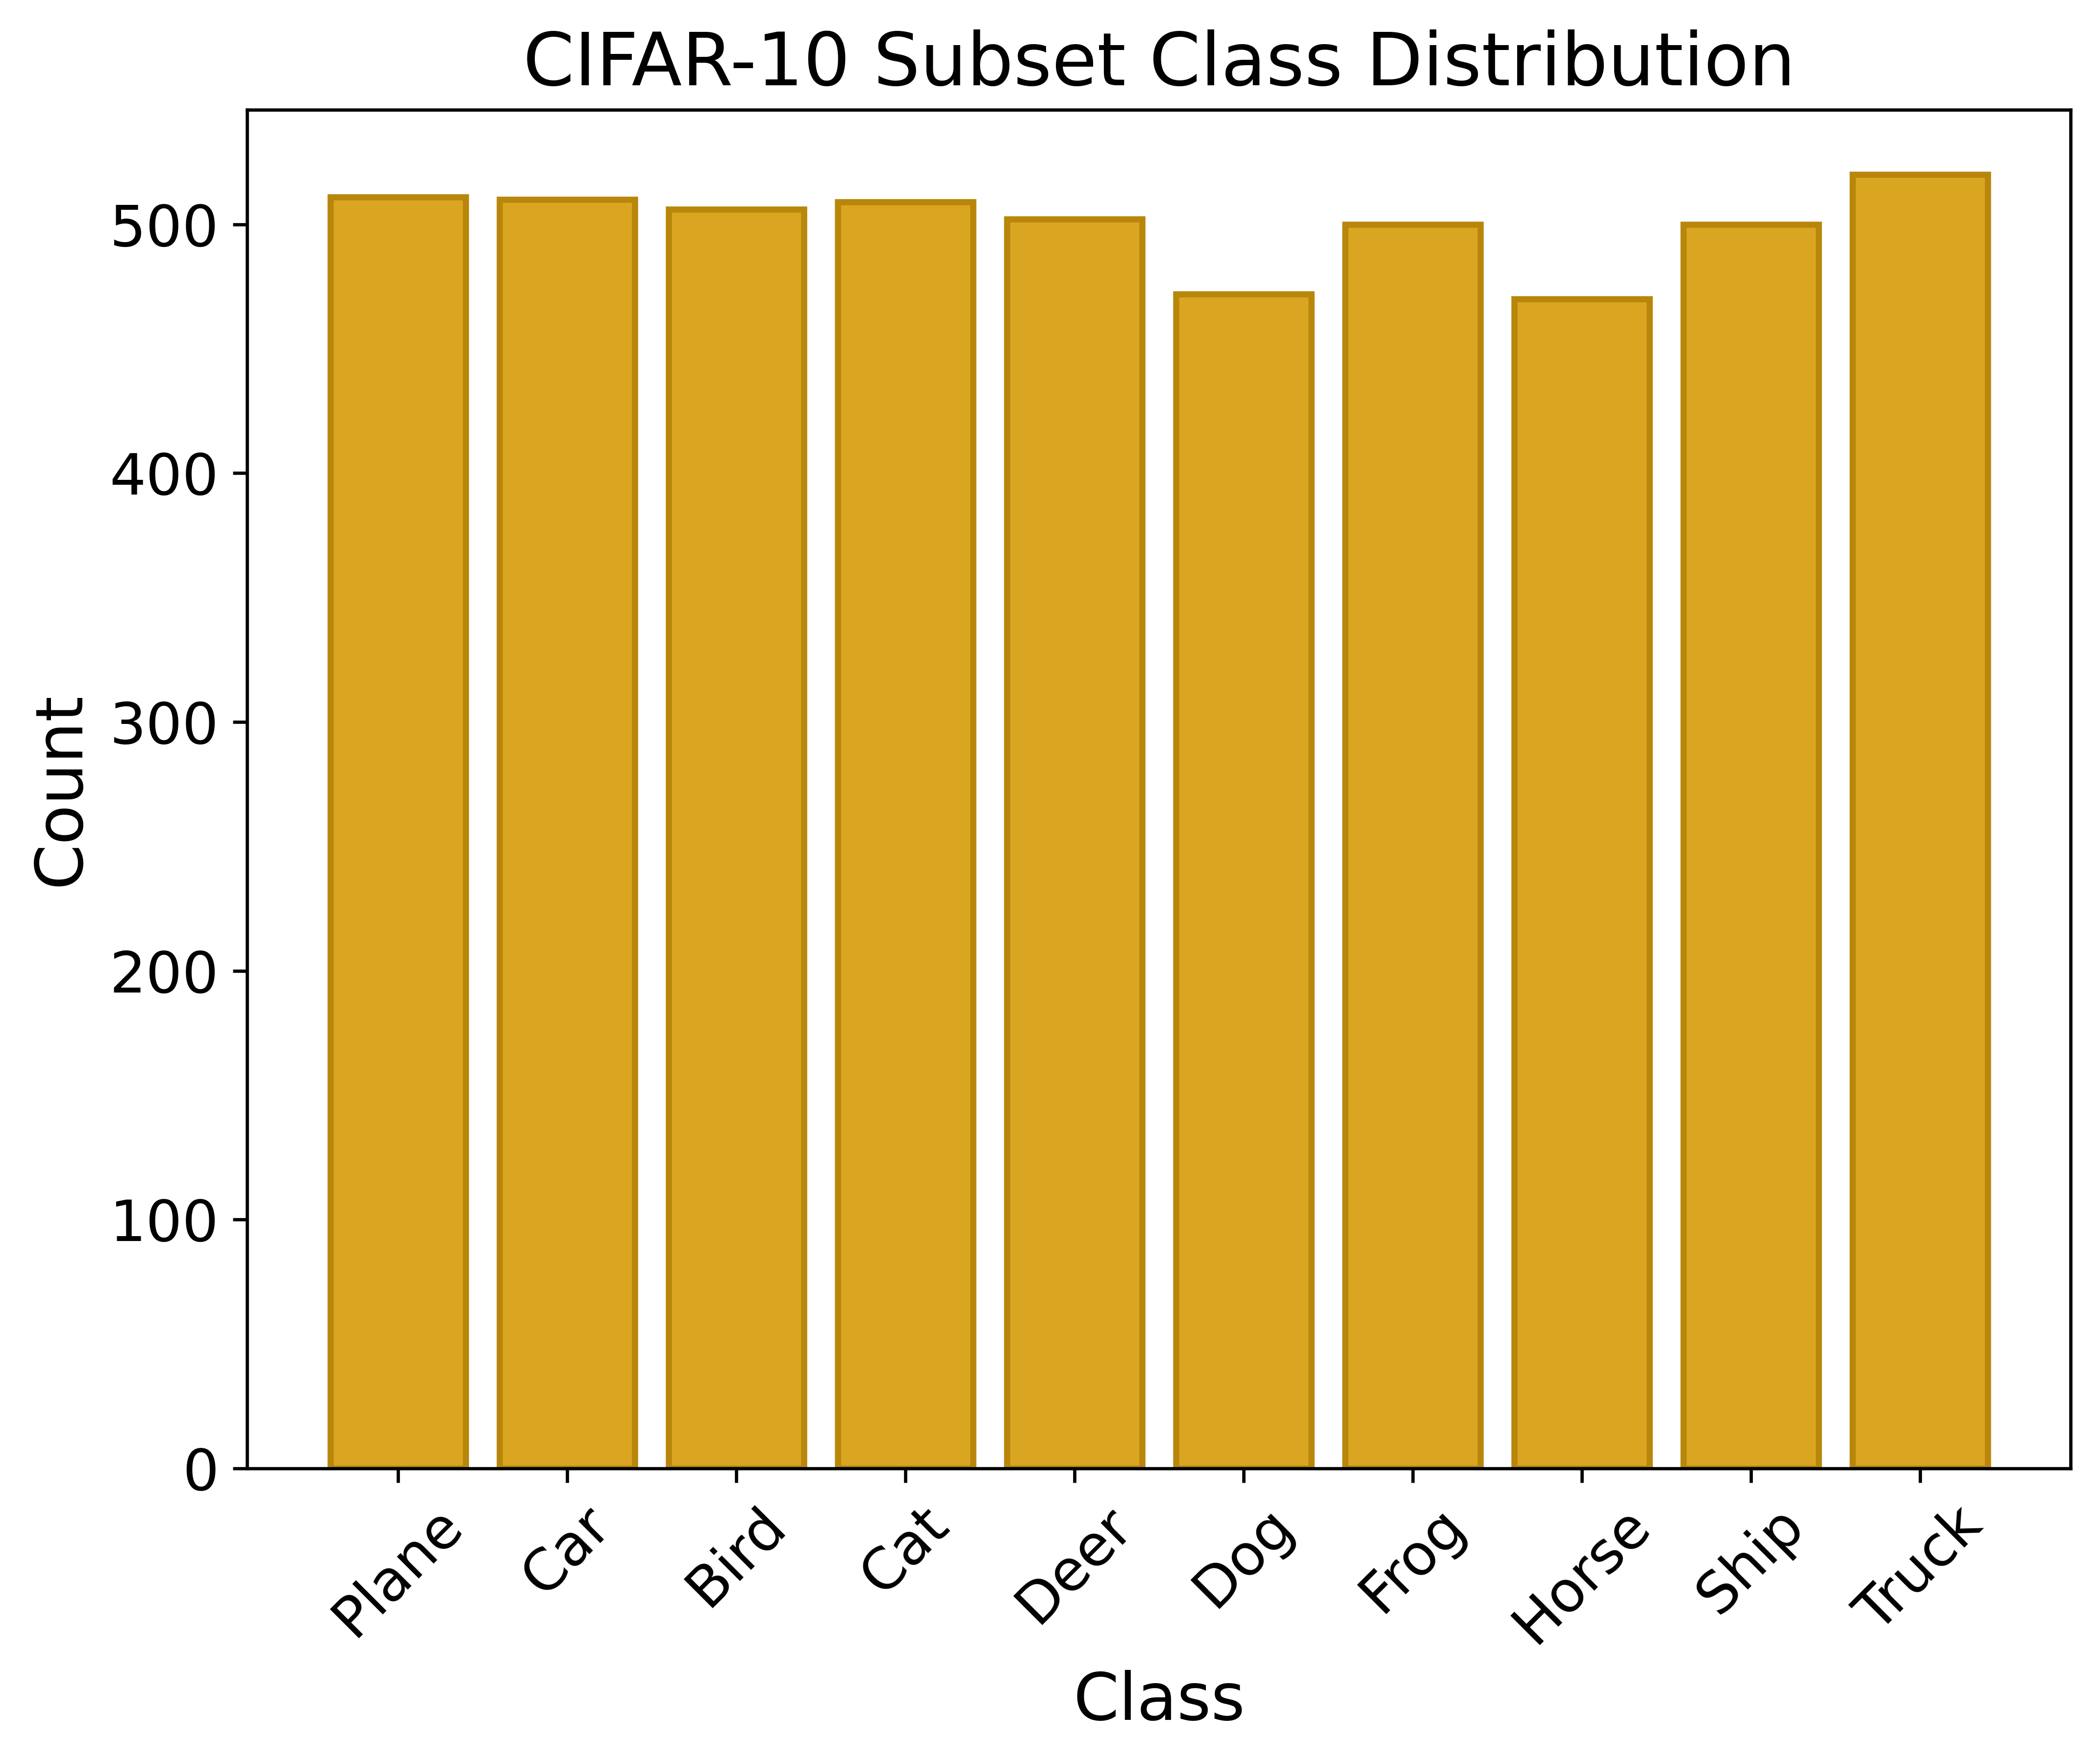

In [4]:
font_size=16

# Create the bar graph
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(classes, label_counts.values(), color='goldenrod', edgecolor='darkgoldenrod', linewidth=1.5)

# Add labels and title
plt.xlabel('Class', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.title('CIFAR-10 Subset Class Distribution', fontsize=font_size+2)

# Rotate the x-axis labels for better visibility if needed
plt.xticks(rotation=45, fontsize=font_size-2)
plt.yticks(fontsize=font_size-2)

# Show the plot
plt.show()

### Group labels into animal and inanimate (source of bias)

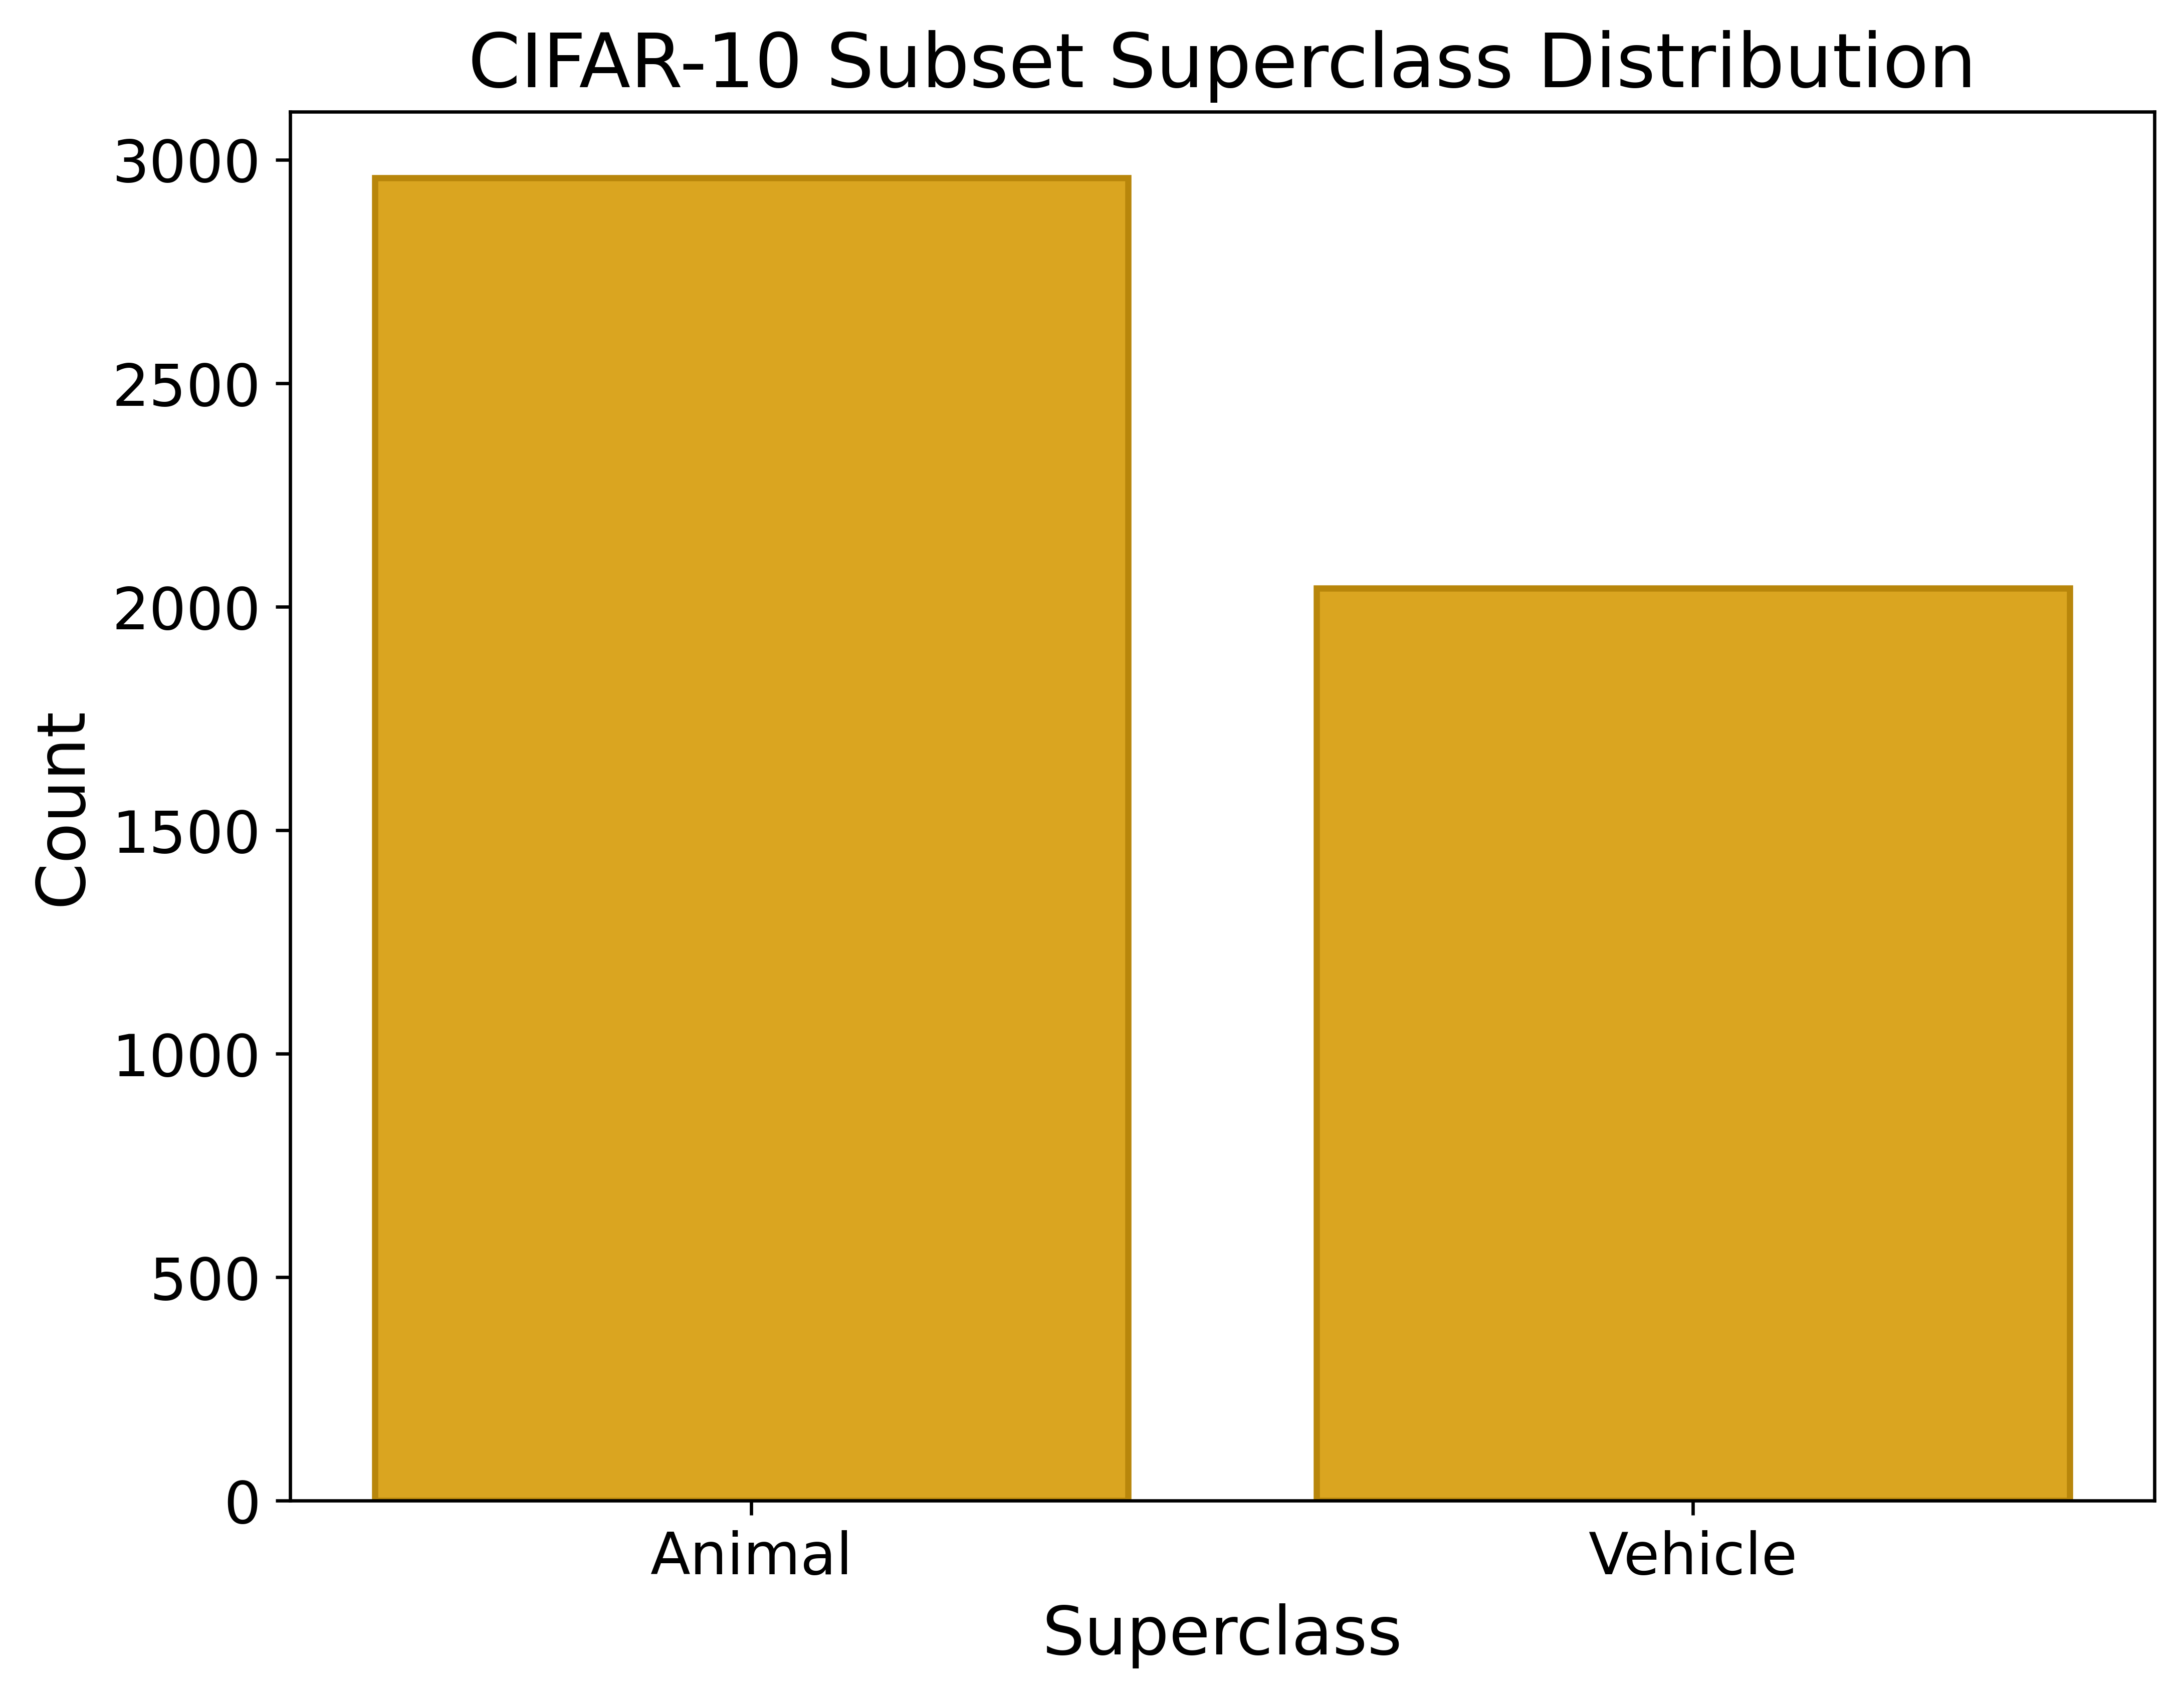

2959 Animals, 2041 Vehicles


In [5]:
font_size = 16

superclasses = ['Animal', 'Vehicle']

animals_counts = sum([label_counts[label] for label in [2, 3, 4, 5, 6, 7]])
inanimate_counts = sum([label_counts[label] for label in [0, 1, 8, 9]])

# Create the bar graph
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(superclasses, [animals_counts, inanimate_counts], color='goldenrod',
    edgecolor='darkgoldenrod', linewidth=1.5)

# Add labels and title
plt.xlabel('Superclass', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.title('CIFAR-10 Subset Superclass Distribution', fontsize=font_size+2)

# Increase font size of x and y axis tick labels
plt.xticks(fontsize=font_size-2)
plt.yticks(fontsize=font_size-2)

# Show the plot
plt.show()

print(animals_counts, 'Animals,', inanimate_counts, 'Vehicles')

### Get count for debiasing
For debiasing, we look at matching the superclass counts. For the superclass to augment, we match the individual class count proportions found in the predetermined random subset.

In [6]:
class_to_generate = superclasses[0] if inanimate_counts > animals_counts else superclasses[1]
num_generate = abs(animals_counts - inanimate_counts)
print(f"To debias, generate {num_generate} {class_to_generate} images as follows:")

# Follow subset distribution proportions
inanimate_distribution = [label_counts[label] for label in [0, 1, 8, 9]] # Counts for each inanimate class in the random subset
inanimate_proportions = [(count / sum(inanimate_distribution)) for count in inanimate_distribution] # Proportions for each inanimate class in the random subset
count_generate = [round(num_generate * label_count) for label_count in inanimate_proportions] # Number of each class to generate
assert sum(count_generate) == num_generate, "Sanity check failed: individual class counts don't sum to total generated count" # Sanity check that summing the individual class generation counts equals total generation count

inanimate_labels = [classes[label] for label in [0, 1, 8, 9]] # Get inanimate class names
for count, label in zip(count_generate, inanimate_labels):
    print(f"- {label}: {count}")


To debias, generate 918 Vehicle images as follows:
- Plane: 230
- Car: 229
- Ship: 225
- Truck: 234


### Load synthetic images
Code adapted from Utkarsh Garg at Towards Data Science:
https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [7]:
data_path = 'data/cifar-10-synthetic'

image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for i_data_path in glob.glob(data_path + '/*'):
    if (os.path.isdir(i_data_path) and i_data_path.split('/')[-1] != 'batch_previews'):
        classes.append(i_data_path.split('/')[-1]) 
        image_paths.append(glob.glob(i_data_path + '/*'))
    
image_paths = list(flatten(image_paths))
# random.shuffle(image_paths)

print('image_path example: ', image_paths[0])
print('class example: ', classes[0])

print("data size: {}".format(len(image_paths)))

#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(idx_to_class)

#######################################################
#               Define Dataset Class
#######################################################
class SyntheticCifarDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        # image = cv2.imread(image_filepath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.open(image_filepath)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(img=image)#["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################
synthetic_cifar_dataset = SyntheticCifarDataset(image_paths,transform)

#######################################################
#                  Define Dataloaders
#######################################################
synthetic_cifar_loader = DataLoader(
    synthetic_cifar_dataset, batch_size=4, shuffle=False
)


image_path example:  data/cifar-10-synthetic\airplane\s_airplane_00000.jpg
class example:  airplane
data size: 2816
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


### Calculate counts with augmented dataset

In [8]:
# Mapping for count_generate indexing
classes_to_generate = [0, 1, 8, 9]
mapping = {0: 0, 1: 1, 8: 2, 9: 3}
reversed_mapping = {value: key for key, value in mapping.items()}
new_values = [mapping[old_value] for old_value in classes_to_generate]

# Target_generated_counts: for labels to generate, add existing count to the count to generate
target_generated_counts = count_generate.copy()
for idx, class_count in enumerate(count_generate):
    target_generated_counts[idx] += label_counts[reversed_mapping[idx]]

# Iterate through the subset and count the occurrences of each label
for images, labels in synthetic_cifar_loader:
    for label in labels:
        label_id = label.item()
        if label_id in classes_to_generate:
            if label_counts[label_id] < target_generated_counts[mapping[label_id]]: # Only take the number of images as called for above
                label_counts[label_id] += 1

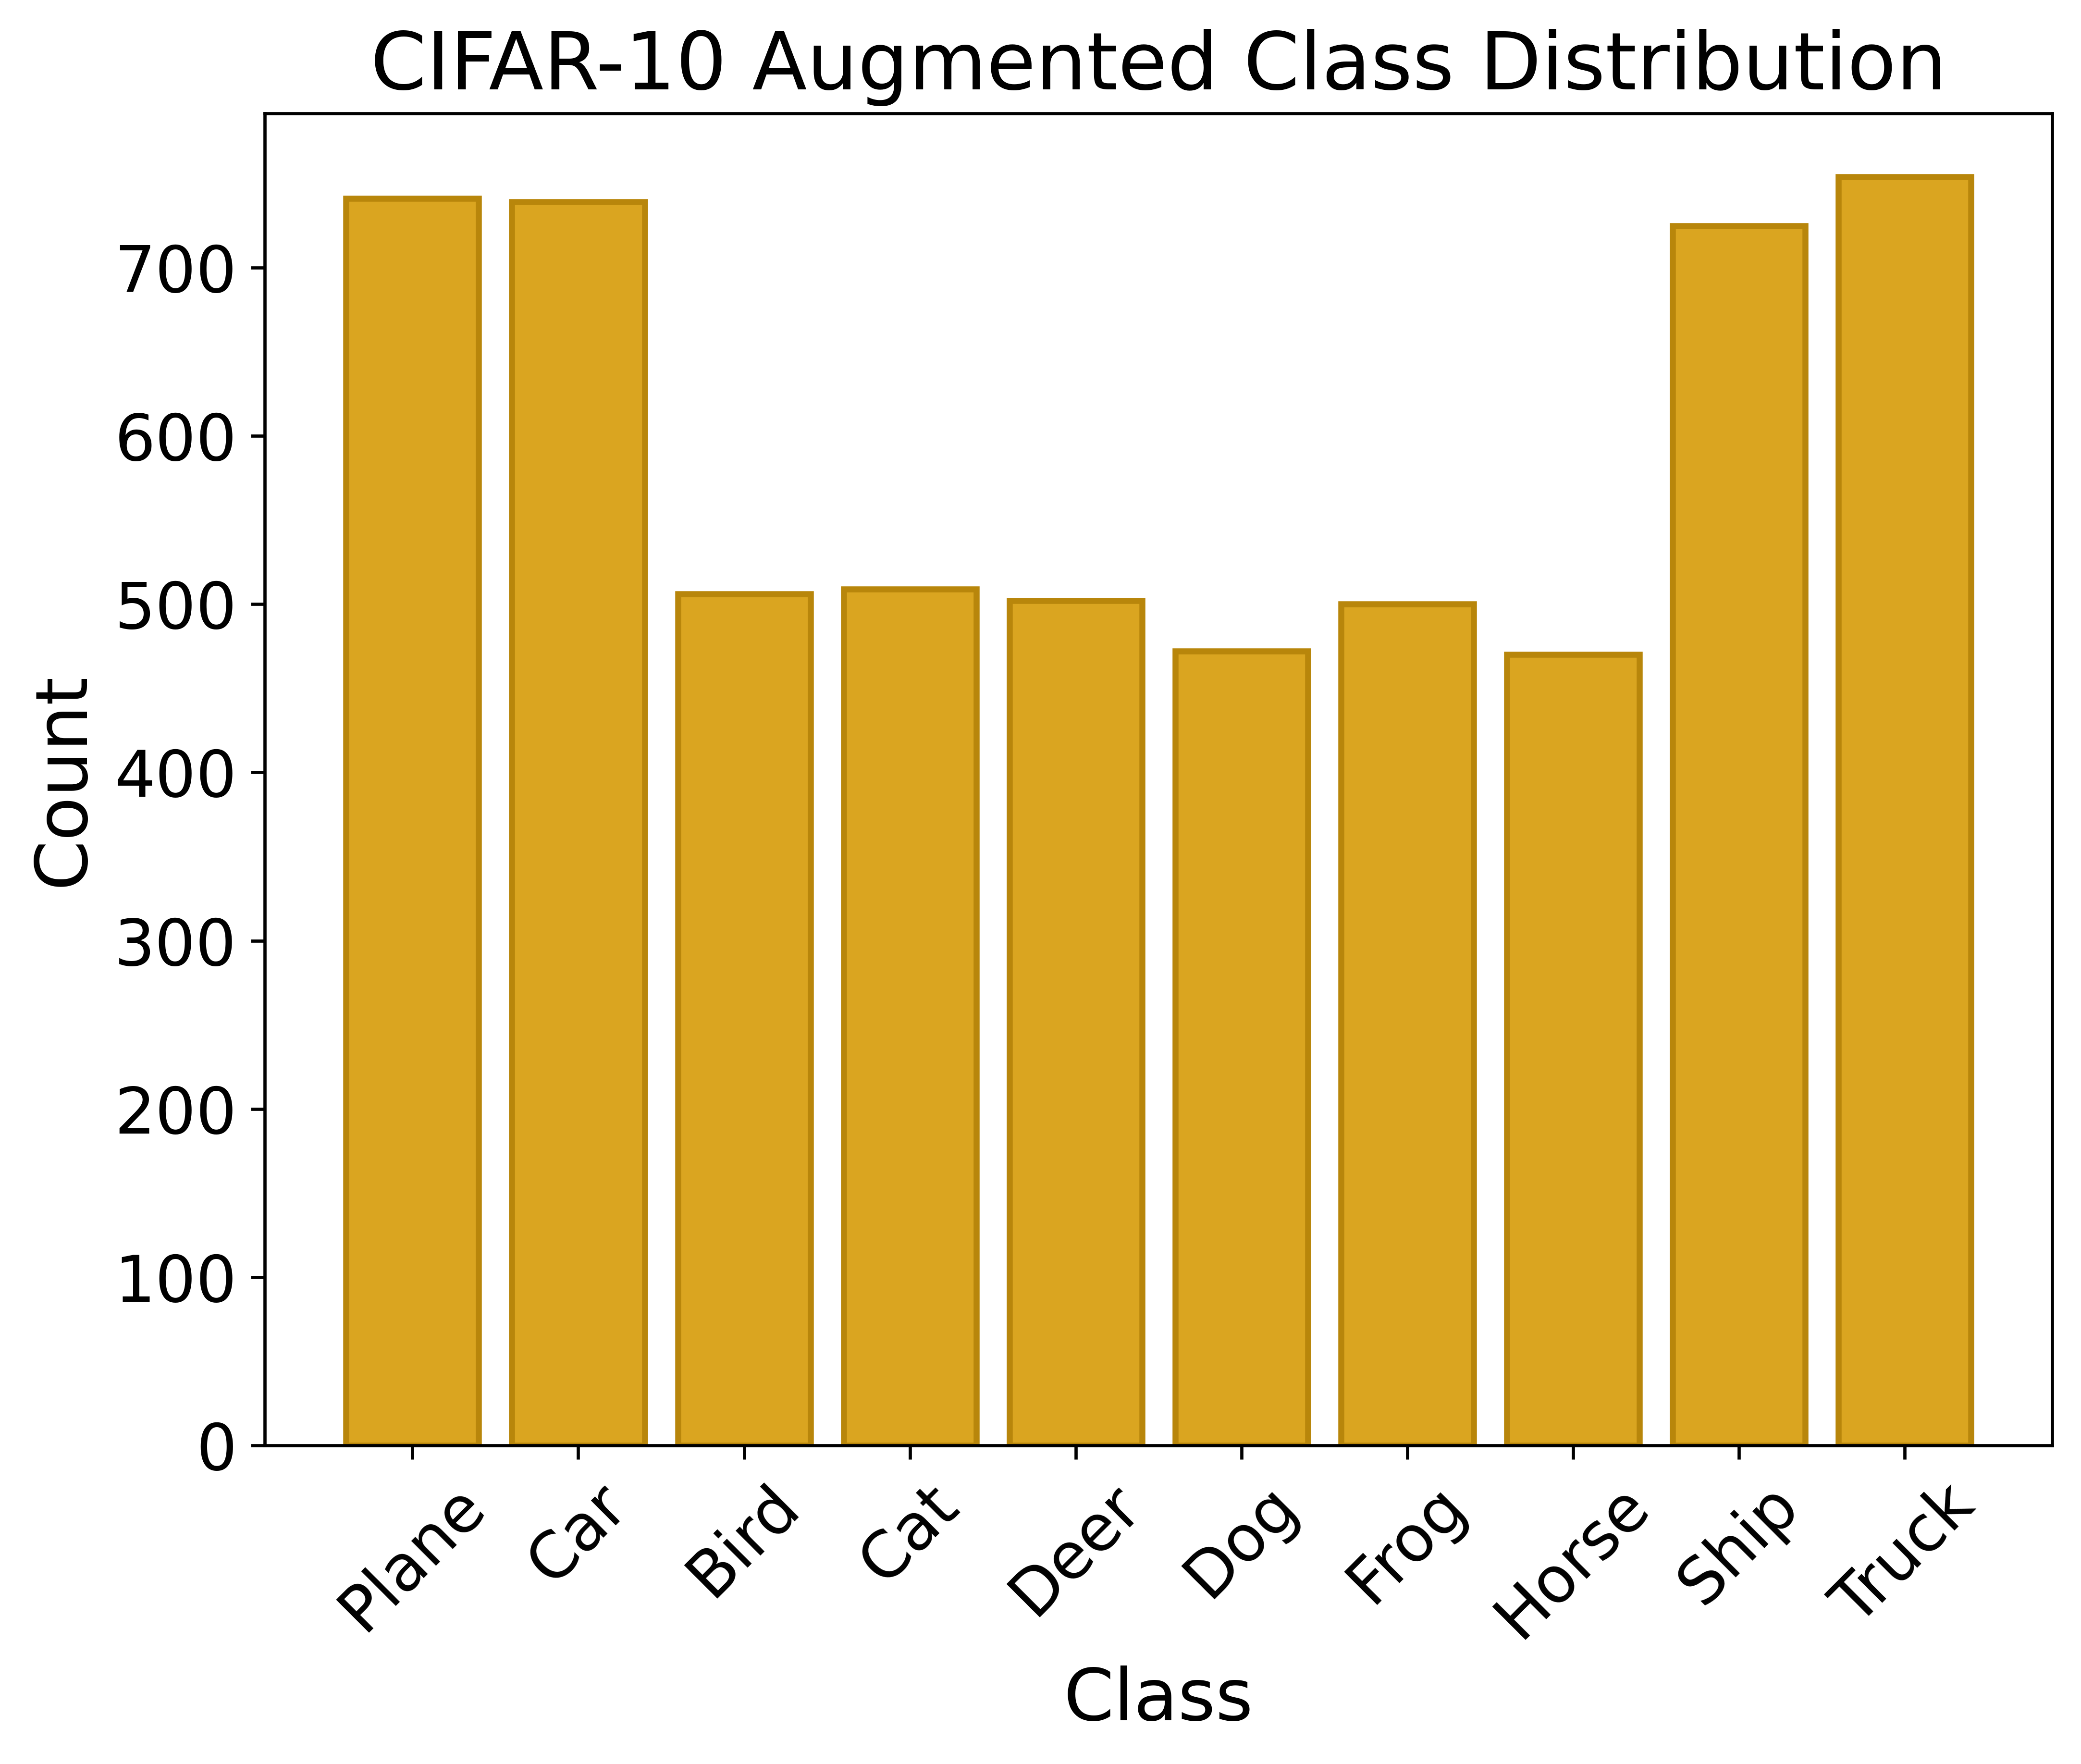

{0: 741, 1: 739, 2: 506, 3: 509, 4: 502, 5: 472, 6: 500, 7: 470, 8: 725, 9: 754}


In [9]:
font_size = 18

classes = ('Plane', 'Car', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Create the bar graph
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(classes, label_counts.values(), color='goldenrod', edgecolor='darkgoldenrod', linewidth=1.5)

# Add labels and title
plt.xlabel('Class', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.title('CIFAR-10 Augmented Class Distribution', fontsize=font_size+2)

# Rotate the x-axis labels for better visibility if needed
plt.xticks(rotation=45, fontsize=font_size-2)
plt.yticks(fontsize=font_size-2)

# Show the plot
plt.show()

print(label_counts)

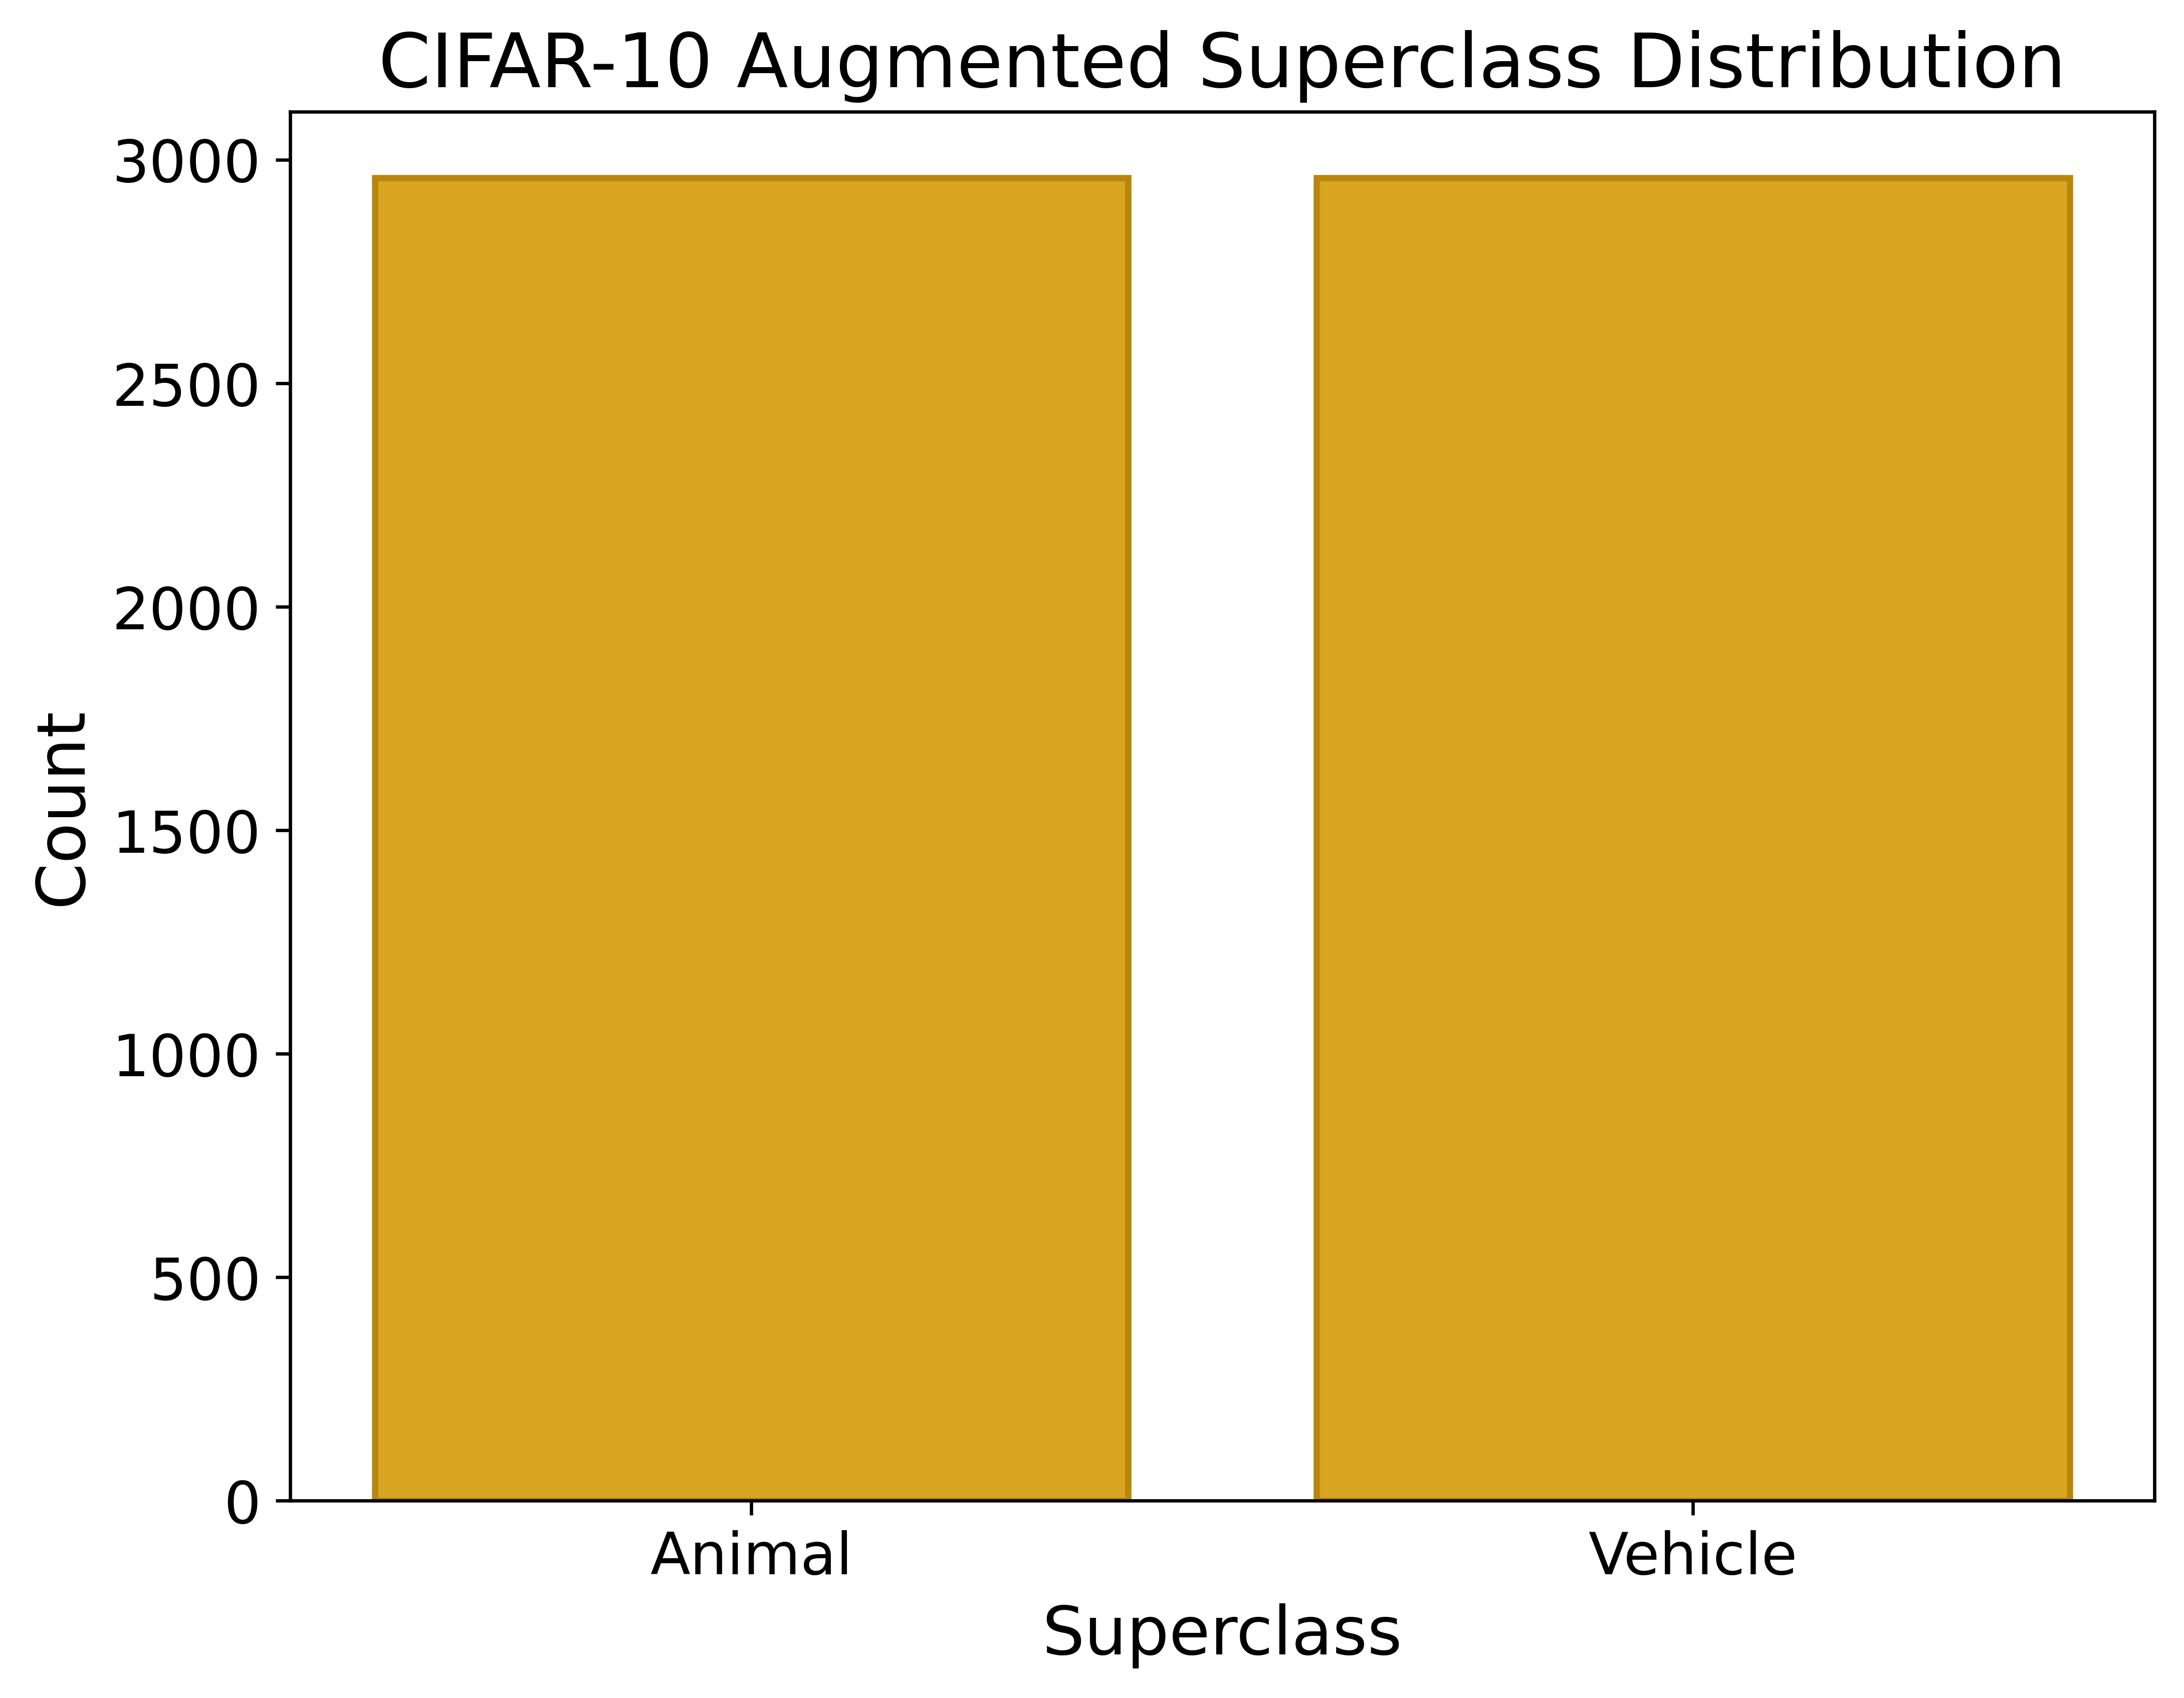

2959 Animals, 2959 Vehicles


In [10]:
font_size = 16

superclasses = ['Animal', 'Vehicle']

animals_counts = sum([label_counts[label] for label in [2, 3, 4, 5, 6, 7]])
inanimate_counts = sum([label_counts[label] for label in [0, 1, 8, 9]])

# Create the bar graph
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(superclasses, [animals_counts, inanimate_counts], color='goldenrod',
    edgecolor='darkgoldenrod', linewidth=1.5)

# Add labels and title
plt.xlabel('Superclass', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.title('CIFAR-10 Augmented Superclass Distribution', fontsize=font_size+2)

# Increase font size of x and y axis tick labels
plt.xticks(fontsize=font_size-2)
plt.yticks(fontsize=font_size-2)

# Show the plot
plt.show()

print(animals_counts, 'Animals,', inanimate_counts, 'Vehicles')

### Visualize dataset images

In [11]:
images_per_class = 10

# Define a function to randomly sample images from each class
def random_sample_images(dataset, classes, num_samples=10):
    class_images = [[] for _ in range(len(classes))]
    
    for data, target in dataset:
        class_images[target].append(data)
    
    sampled_images = []
    for class_idx in range(len(classes)):
        sampled_images.extend(random.sample(class_images[class_idx], num_samples))
    
    # Convert sampled_images list to a tensor array
    sampled_images_tensors = torch.stack(sampled_images)
    
    return sampled_images_tensors

# Randomly sample 10 images from each class and convert to tensor array
subset_sampled_images = random_sample_images(subset_trainset, trainset.classes, num_samples=images_per_class)
synthetic_sampled_images = random_sample_images(synthetic_cifar_dataset, trainset.classes, num_samples=images_per_class)


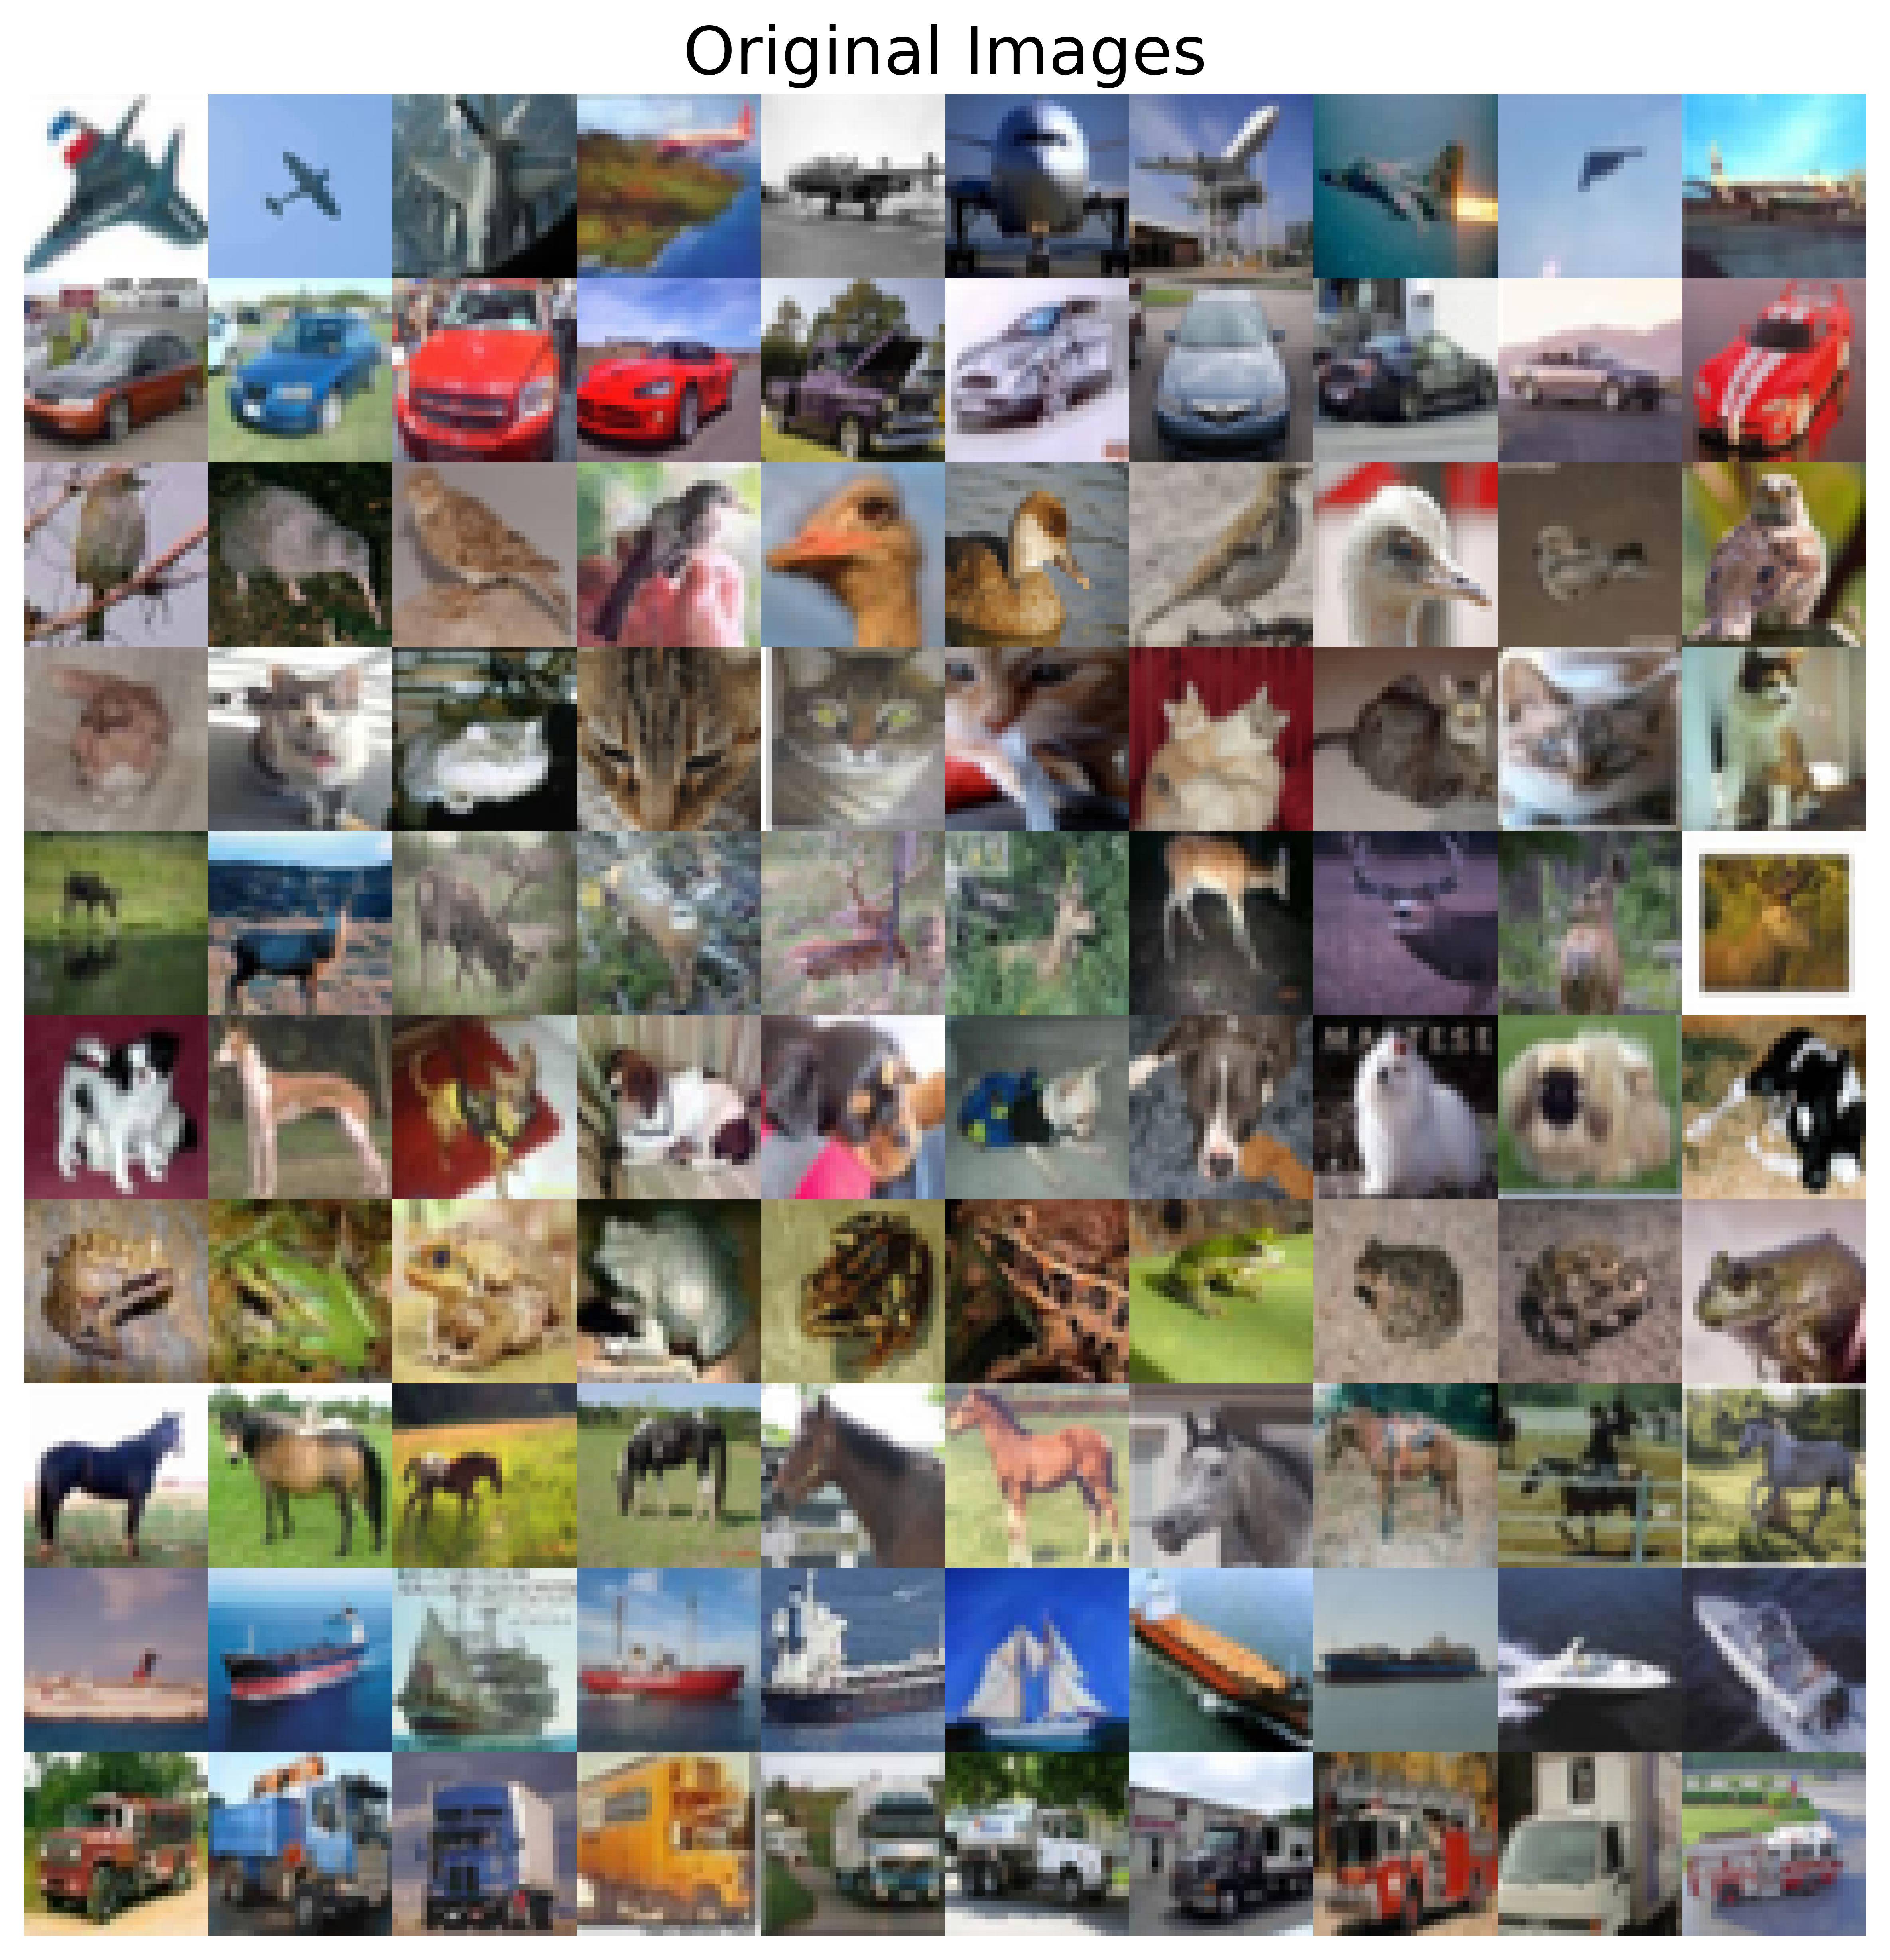

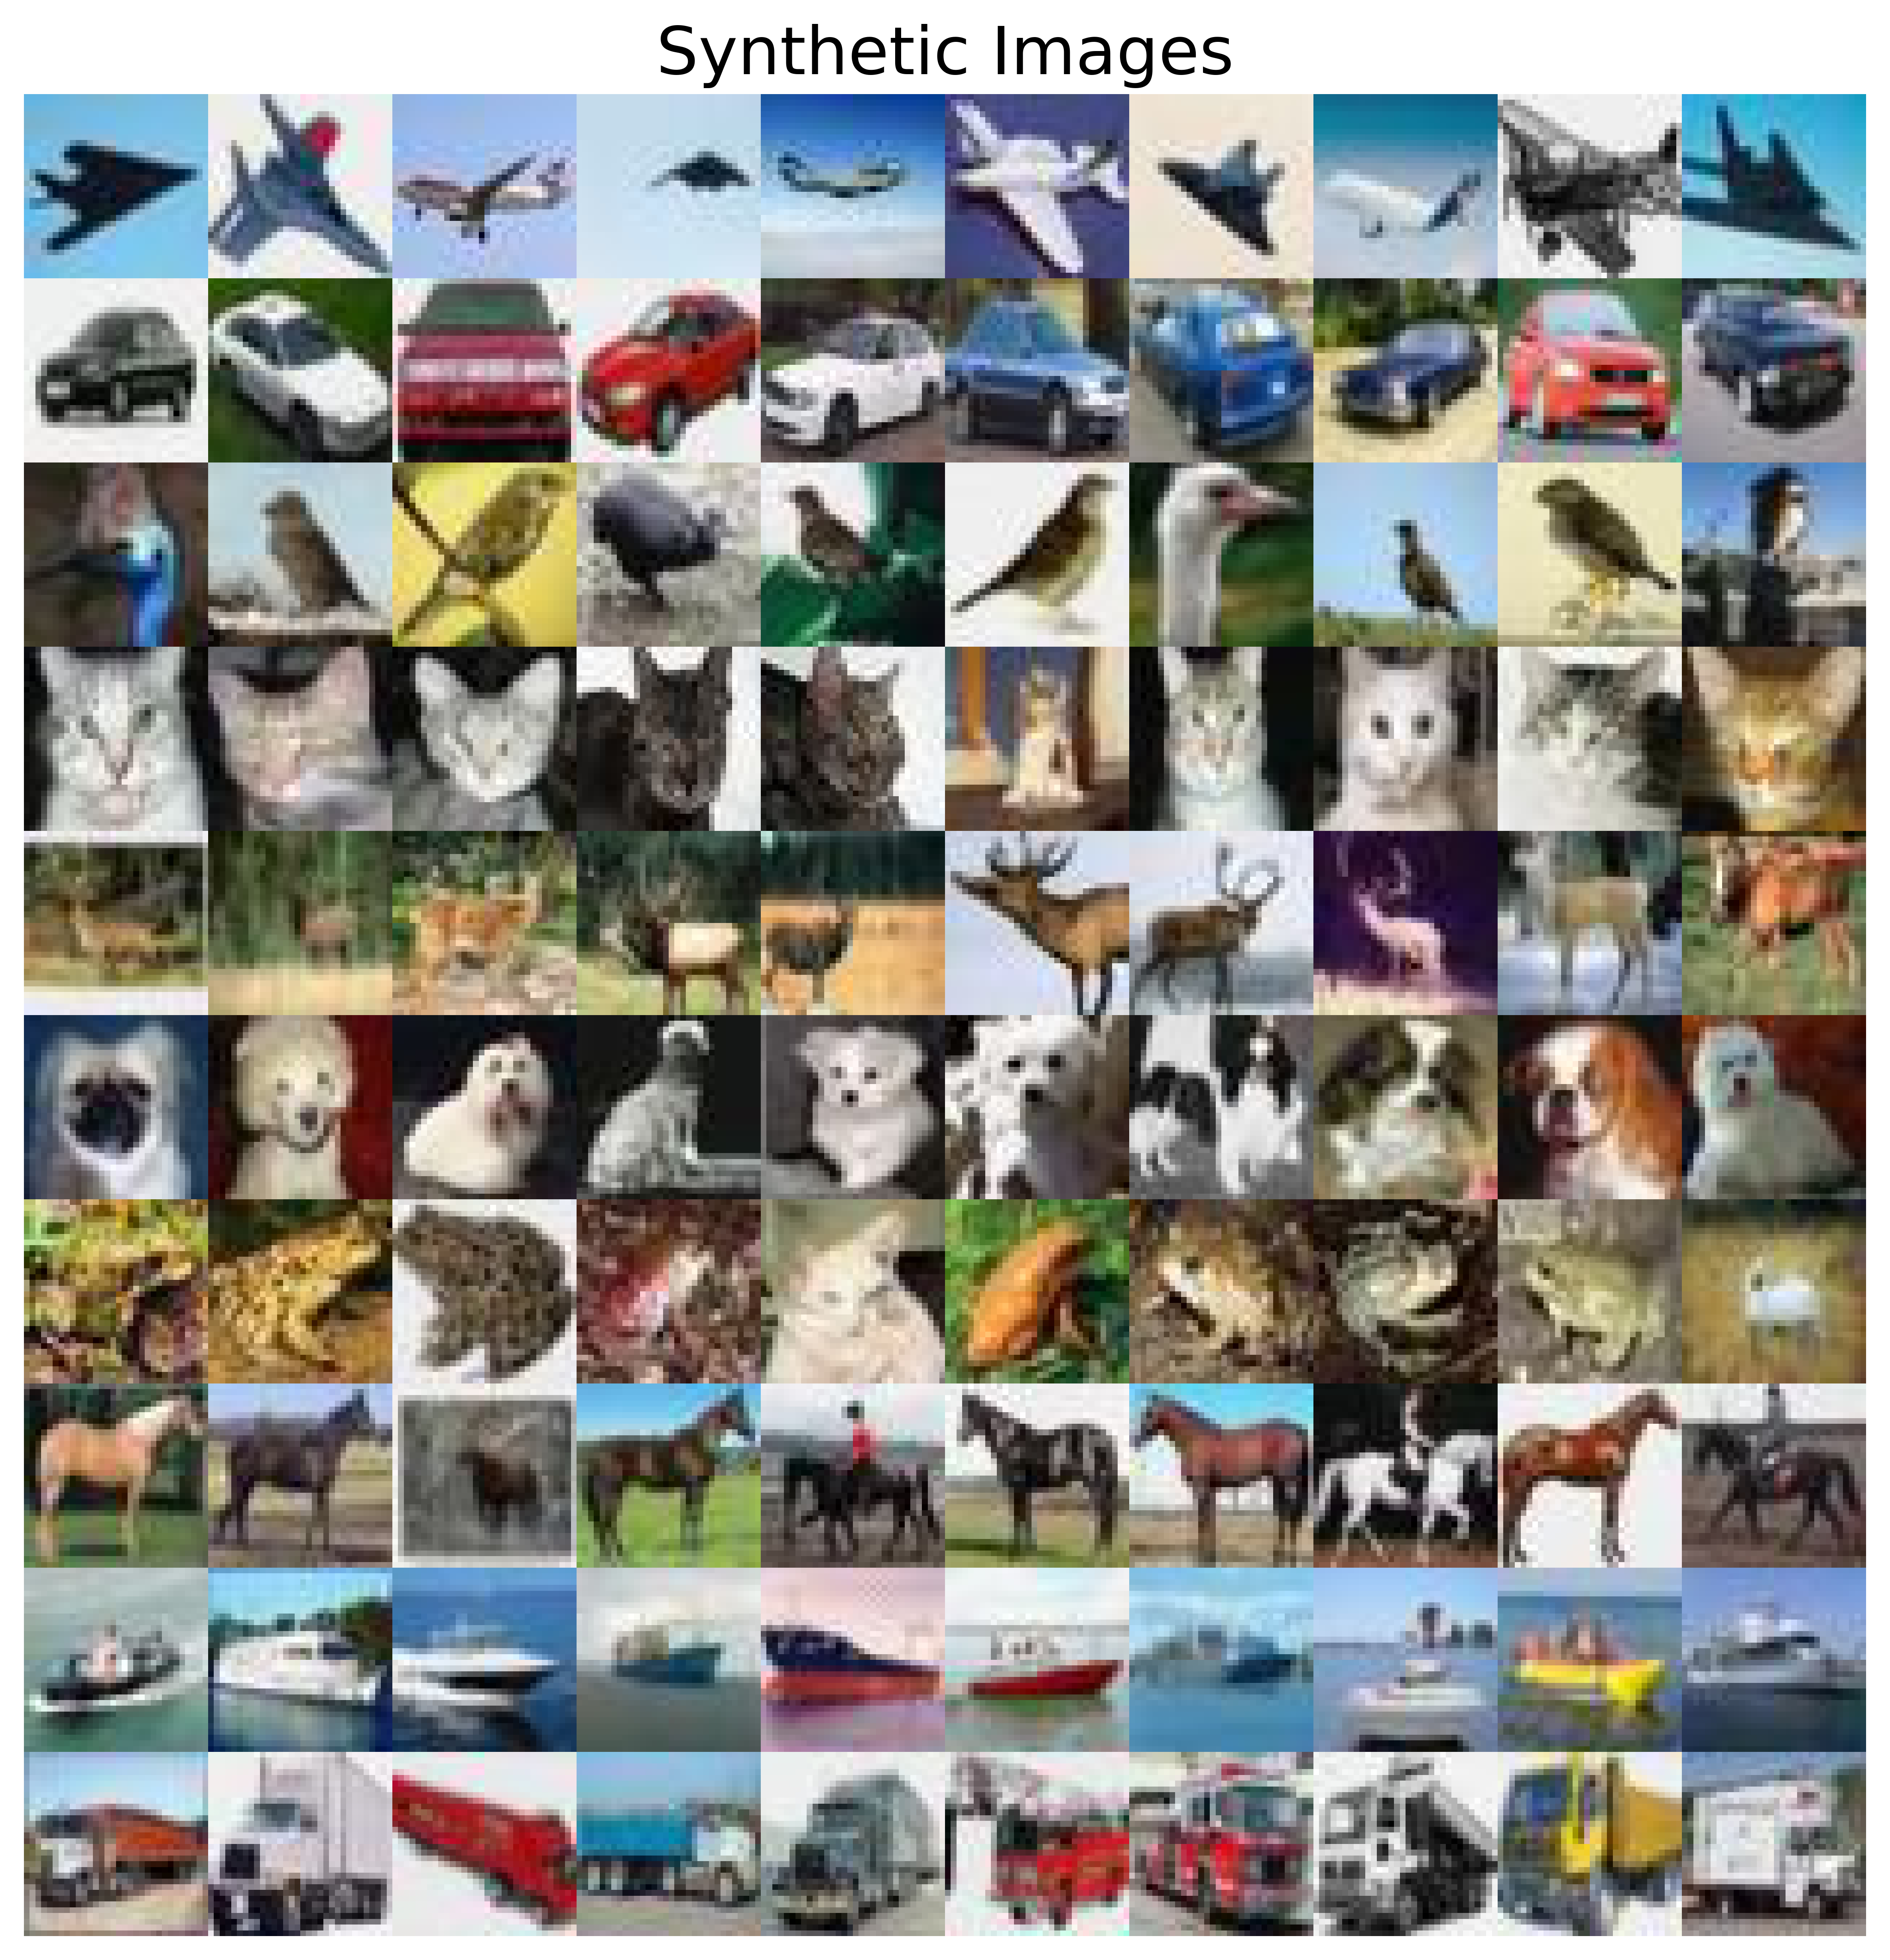

In [12]:
font_size=20

def image_grid(images, rows, cols, image_size):
    batch_size, channels, height, width = images.shape
    grid = torch.zeros((channels, rows * image_size, cols * image_size))

    for r in range(rows):
        for c in range(cols):
            image_idx = r * cols + c
            if image_idx < batch_size:
                start_x = c * image_size
                start_y = r * image_size
                end_x = start_x + image_size
                end_y = start_y + image_size
                grid[:, start_y:end_y, start_x:end_x] = images[image_idx]

    return grid.permute(1, 2, 0)

def show_samples(images, cols=10, title=""):
    img = image_grid(images, rows=10, cols=cols, image_size=32)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(title, fontsize=font_size)
    plt.imshow(img)
    plt.show()

# Call the show_samples function
show_samples(subset_sampled_images, cols=images_per_class, title="Original Images")
show_samples(synthetic_sampled_images, cols=images_per_class, title="Synthetic Images")
